In [1]:
import os; os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from urbanstats.games.quiz_analysis import get_full_statistics, questions

In [4]:
 plt.rcParams["font.family"] = "monospace"

In [5]:
result = get_full_statistics(after_problem=49, debug=False)
num_users_by_problem = result.groupby("problem").count().user_id
means = result[["problem", "score", *questions]].groupby("problem").mean()

/home/kavi/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


In [6]:
def line_histogram(offs, weights=None, dx=0.5):
    bin_sides = offs // dx * dx
    bins = np.arange(bin_sides.min(), bin_sides.max() + 1, dx)
#     plt.hist(offs, bins=bins, alpha=0.5, label=f"J{time}; total={offs.shape[0]}")
    y, be = np.histogram(offs, weights=weights, bins=bins)
    x = (be[1:] + be[:-1]) / 2
    return x, y

In [7]:
def plot():
    plt.figure(dpi=200, facecolor="white")
    for time in range(result.problem.min(), 1 + result.problem.max()):
        offs = result[(result.problem == time) & (result.last_in_batch == 1)].offset
        plt.plot(*line_histogram(offs), label=f"J{time}; total={offs.shape[0]}", lw=0.5)
    plt.xticks(rotation=90)
    plt.xlabel("Hours after EDT release")
    plt.ylabel("Frequency")
    lo, hi = plt.xlim()
    lo = lo // 4 * 4
    hi = hi // 4 * 4 + 4
    plt.xticks(np.arange(lo, hi + 4, 4))
    plt.grid()
    # plt.axvline(1.5, color="red", lw=0.5, label="Graph Crimes Post")
    # for h in 0, 1, 2, 3, 24, 25, 26, 27:
    #     plt.axvline(h, color="black", lw=0.5)
    plt.legend()
    plt.show()

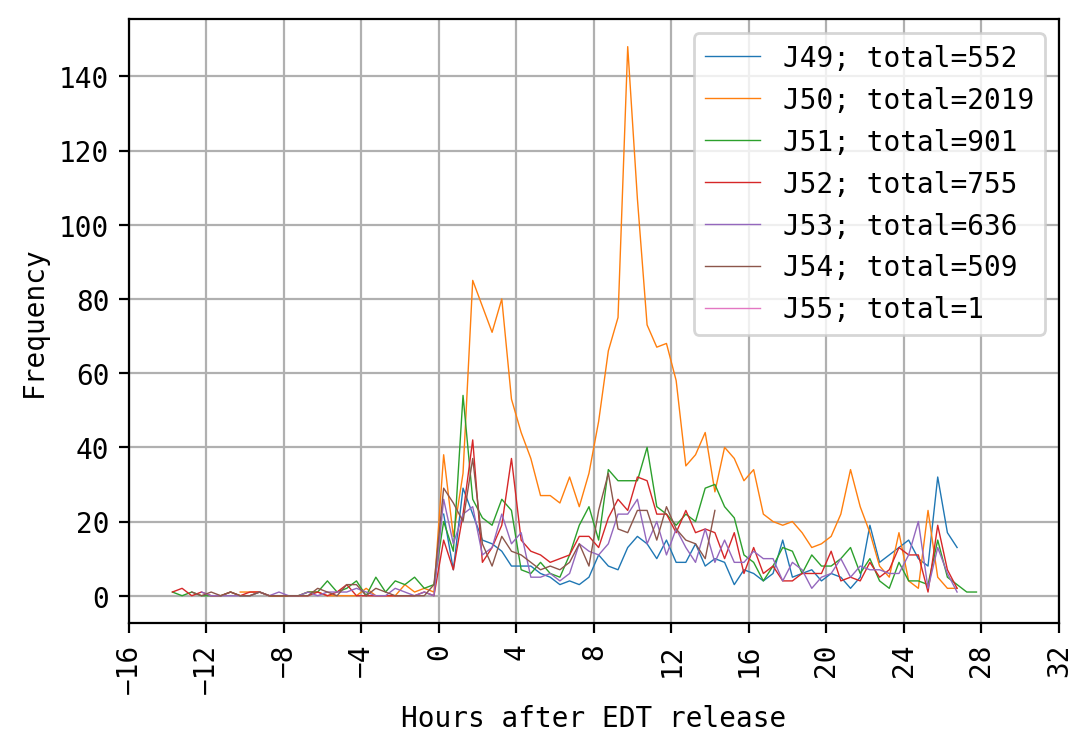

In [8]:
plot()

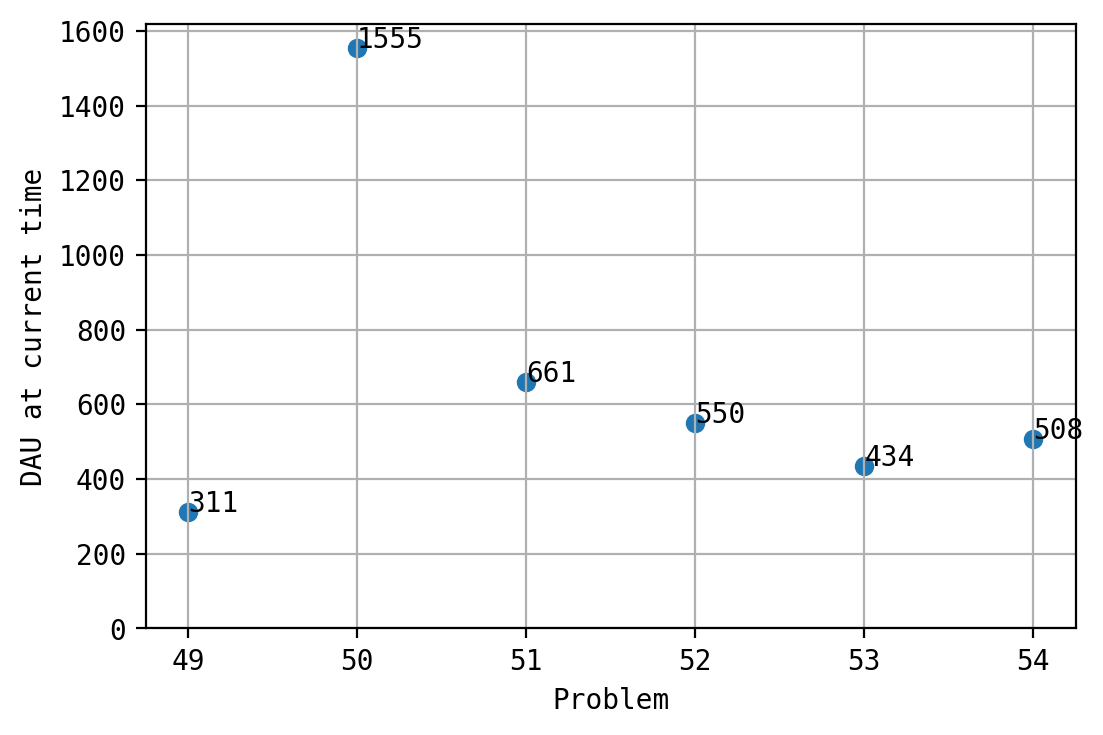

In [9]:
count_by_day = result[["problem", "last_in_batch"]].groupby("problem").sum().rename(columns={"last_in_batch": "c"})
today = count_by_day.index[count_by_day.c > 30].max()
time = result[result.problem == today].offset.max()
at_time = result[(result.offset < time) & (result.problem <= today)].groupby("problem").sum().last_in_batch
plt.figure(dpi=200)
plt.scatter(at_time.index, at_time)
for x in at_time.index:
    plt.text(s=int(at_time[x]), x=x, y=at_time[x])
plt.xlabel("Problem")
plt.ylabel("DAU at current time")
plt.ylim(0, plt.ylim()[1])
plt.grid()
plt.show()

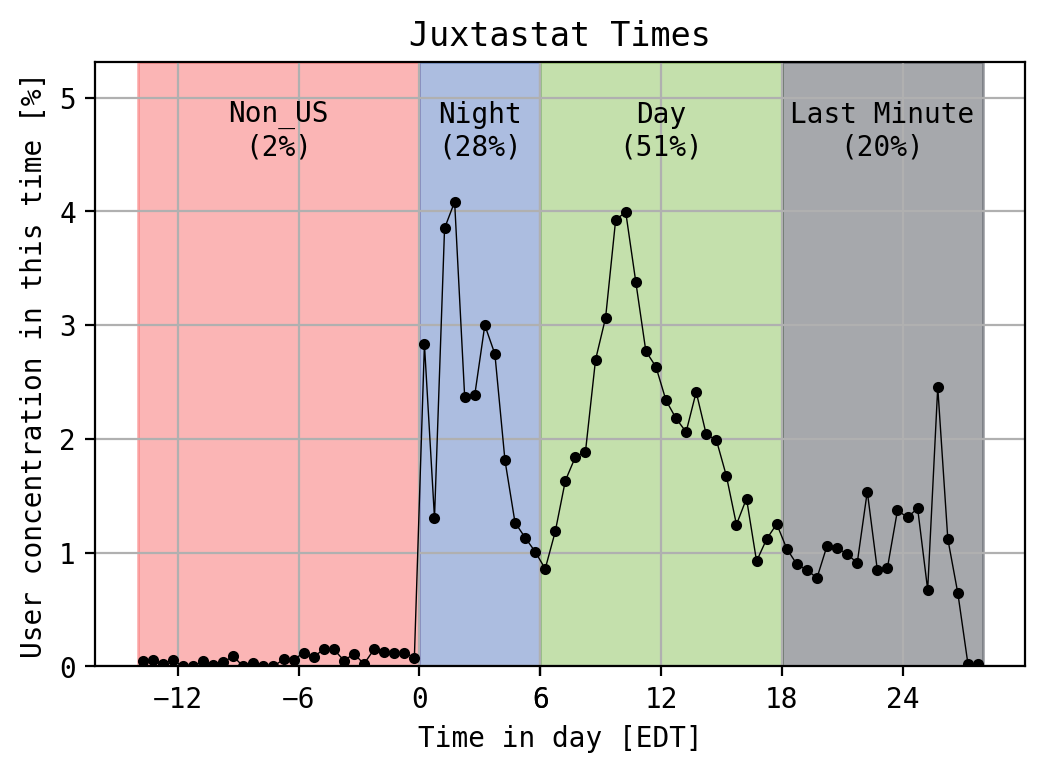

In [10]:
plt.figure(dpi=200)
pre_today = result[(result.problem < today) & (result.last_in_batch == 1)]
time_all = pre_today.offset
weights = 1 / pre_today.groupby("problem").count().user_id[pre_today.problem]
weights /= weights.sum()
x, y = line_histogram(time_all, weights=100 * weights, dx=0.5)
plt.plot(
    x, y,
    lw=0.5,
    marker=".",
    color="black"
)
plt.xlabel("Time in day [EDT]")
plt.ylabel("User concentration in this time [%]")
plt.xticks([-12, -6, 0, 6, 12, 18, 24, 6])


def span(s, e, color, name):
    plt.axvspan(s, e, alpha=0.5, color=color)
    count = np.array(weights)[(s <= time_all) & (time_all < e)].sum() / weights.sum()
    plt.text(x=(s + e) / 2, y=y.max() * 1.1, s=f"{name}\n({count:.0%})", ha="center")


span(-14, 0, "#f96d6d", "Non_US")
span(0, 6, "#5a7dc3", "Night")
span(6, 18, "#8ac35a", "Day")
span(18, 28, "#4e525a", "Last Minute")

plt.title("Juxtastat Times")
plt.ylim(0, y.max() * 1.3)
plt.grid()

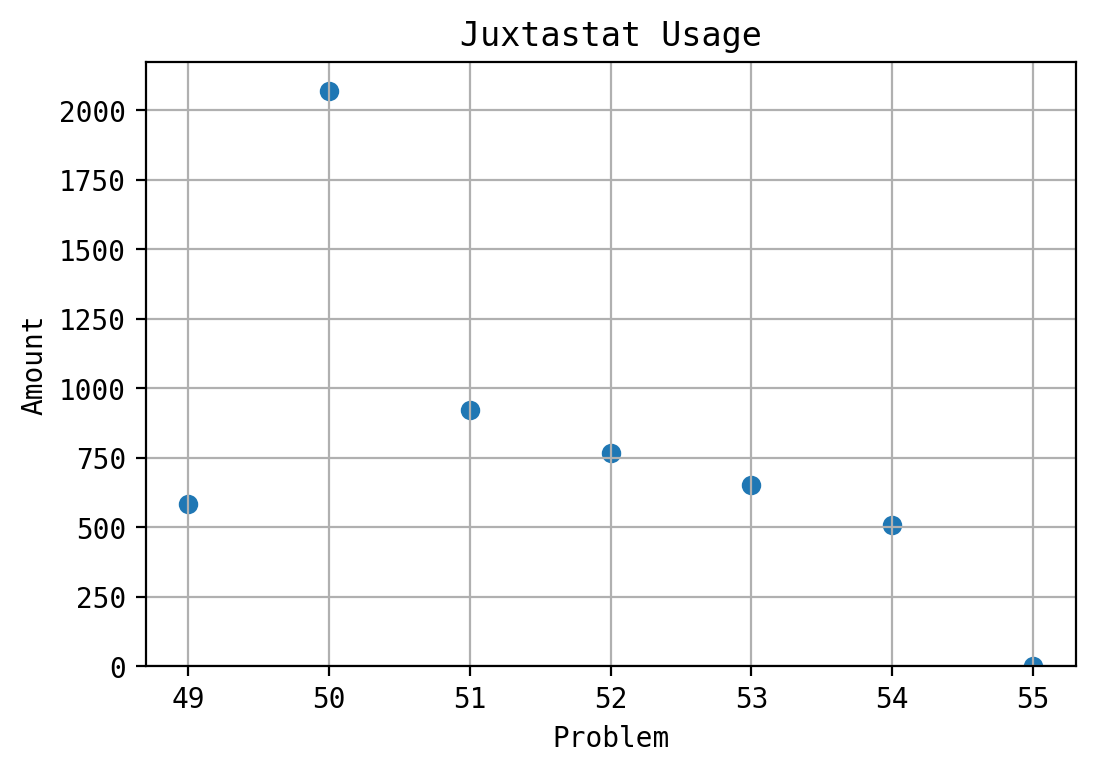

In [11]:
plt.figure(dpi=200)
plt.title("Juxtastat Usage")
plt.scatter(num_users_by_problem.index, num_users_by_problem)
plt.xlabel("Problem")
plt.ylabel("Amount")
plt.ylim(0, plt.ylim()[1])
plt.grid()

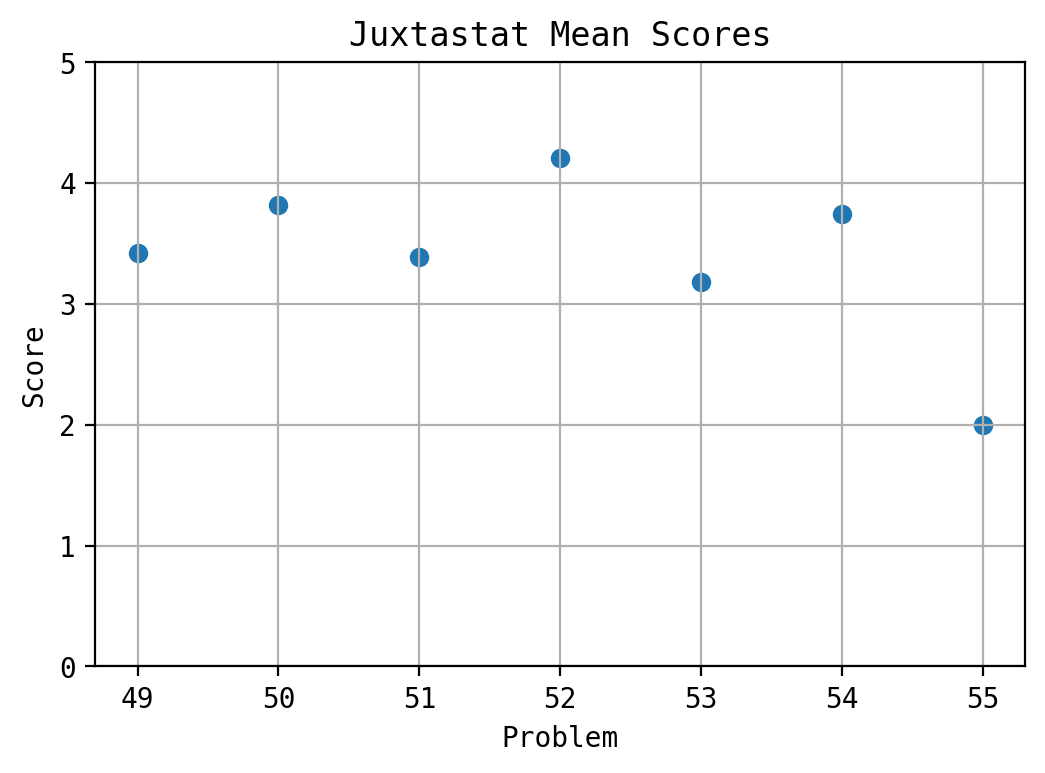

In [12]:
plt.figure(dpi=200)
plt.title("Juxtastat Mean Scores")
plt.scatter(means.index, means.score)
plt.ylim(0, 5)
plt.xlabel("Problem")
plt.ylabel("Score")
plt.grid()

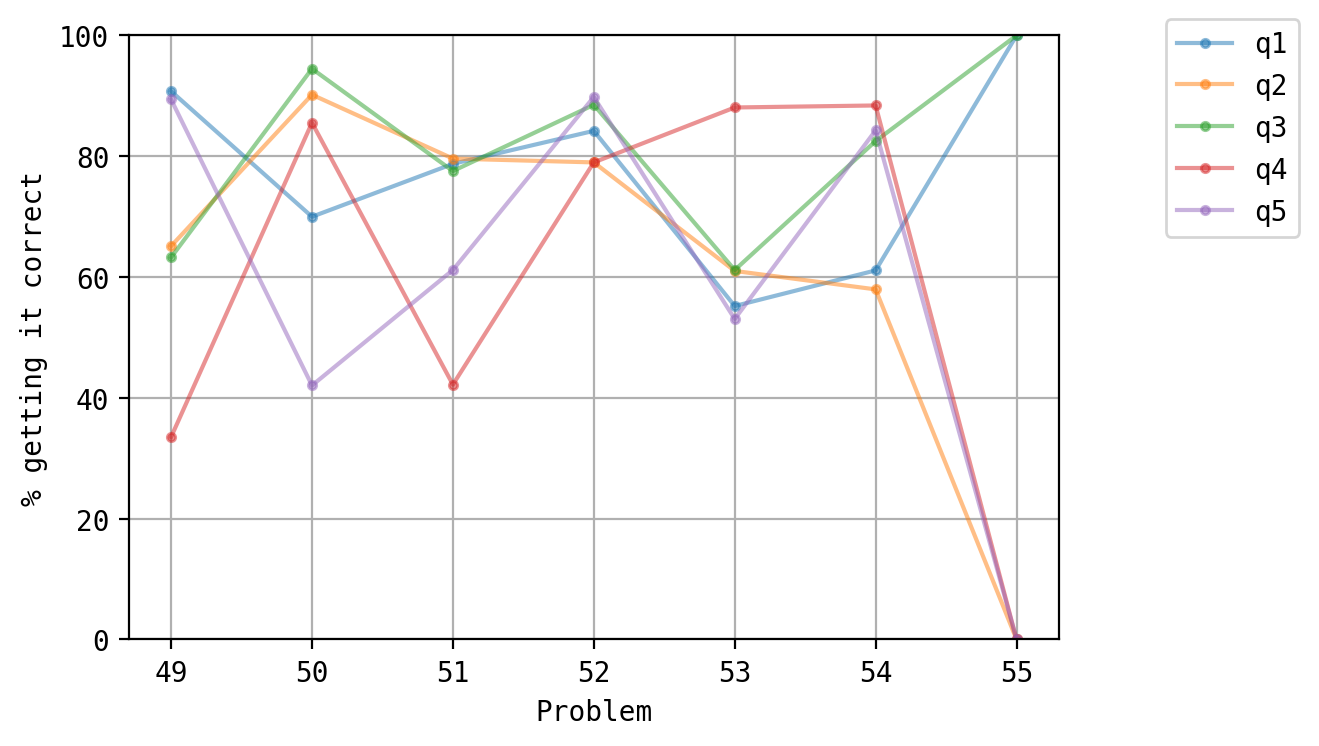

In [13]:
plt.figure(dpi=200)
for q in questions:
    plt.plot(means.index, 100 * means[q], label=q, marker=".", alpha=0.5)
plt.ylim(0, 100)
plt.xlabel("Problem")
plt.ylabel("% getting it correct")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()